In [3]:
## Install the required libraries and packages ##
%%capture  # Suppresses the output of the installations

!pip install datasets    # Library needed to access the dataset
!pip install transformers==4.11.3   # Library needed to access Hugging Face's state-of-the-art pre-trained transformer models
!pip install librosa    # Library needed for audio and music processing and analysis
!pip install jiwer    # Library needed to calculate the word error rate (WER) of the ASR models
!pip install ipywidgets   # Library for interactive widgets in Jupyter notebooks
!pip install torch   # Library needed for the PyTorch deep and machine learning framework

In [9]:
## Load each dataset split individually. This needs to be done manually for all the models ##

from datasets import load_dataset
samromur_milljon = load_dataset("language-and-voice-lab/samromur_milljon", split="female_lt_18_yrs")

# Female speakers less than 18 years old (n < 18): female_lt_18_yrs 

# Female speakers from 18 to 49 years old (18 <= n <=49): female_18to49_yrs 

# Female speakers greater than 49 years old (n > 49): female_gt_49_yrs 

# Male speakers less than 18 years old (n < 18): male_lt_18_yrs 

# Male speakers from 18 to 49 years old (18 <= n <=49): male_18to49_yrs 

# Male speakers greater than 49 years old (n > 49): male_gt_49_yrs 

# Speakers where age, gender or both are unknown: other

C:\Users\gudjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\datasets\load.py:1486: FutureWarning: The repository for language-and-voice-lab/samromur_milljon contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/language-and-voice-lab/samromur_milljon
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [10]:
## Check the column names and the number of rows ##
samromur_milljon

Dataset({
    features: ['audio_id', 'audio', 'speaker_id', 'gender', 'age', 'duration', 'verified_with', 'normalized_text'],
    num_rows: 266005
})

In [11]:
from datasets import DatasetDict

## Split the dataset into training and test datasets ##
split_datasets = samromur_milljon.train_test_split(test_size=0.2, seed=11) # Setting a seed for reproducibility

## Further split the training dataset into training and validation datasets ##
train_val_datasets = split_datasets["train"].train_test_split(test_size=0.125, seed=11) # Setting the same seed here

## Creating a DatasetDict to hold the adjusted splits ##
ds = DatasetDict({
    "train": train_val_datasets["train"], # Use the larger part of the train split for training, 70% of the dataset
    "validation": split_datasets["test"], # Use the initial test split as validation, 10% of the dataset
    "test": train_val_datasets["test"] # Use the smaller part of the train split for testing during training, 20% of the dataset
})

In [12]:
## Check the content of the train, validation and test splits ##
ds

DatasetDict({
    train: Dataset({
        features: ['audio_id', 'audio', 'speaker_id', 'gender', 'age', 'duration', 'verified_with', 'normalized_text'],
        num_rows: 186203
    })
    validation: Dataset({
        features: ['audio_id', 'audio', 'speaker_id', 'gender', 'age', 'duration', 'verified_with', 'normalized_text'],
        num_rows: 53201
    })
    test: Dataset({
        features: ['audio_id', 'audio', 'speaker_id', 'gender', 'age', 'duration', 'verified_with', 'normalized_text'],
        num_rows: 26601
    })
})

In [17]:
from datasets import load_dataset
import numpy as np

# Assuming 'ds' contains your preloaded datasets and 'validation' split is already loaded
validation_dataset = ds['validation']
print("Validation Dataset Loaded, Records Count:", len(validation_dataset))

## Seed for investigating possible seed randomness and to ensure reproducibility. The seeds have to be commented and uncommented manually for each run ##

np.random.seed(42)
#np.random.seed(43)
#np.random.seed(44)

## Shuffle the indices ##
indices = np.random.permutation(len(validation_dataset))

## Calculate split sizes ##
total_count = len(validation_dataset)
first_split_size = total_count // 3
second_split_size = (total_count - first_split_size) // 2

## Create splits ##
split1_indices = indices[:first_split_size]
split2_indices = indices[first_split_size:first_split_size + second_split_size]
split3_indices = indices[first_split_size + second_split_size:]

## Create subsets for the test dataset split based on calculated indices ##
split1 = validation_dataset.select(split1_indices)
split2 = validation_dataset.select(split2_indices)
split3 = validation_dataset.select(split3_indices)

## Output sizes and total duration of each split ##
print("Validation Split 1 Sample Size:", len(split1), ", Total Duration:", sum(split1['duration']) / 3600, "hours")
print("Validation Split 2 Sample Size:", len(split2), ", Total Duration:", sum(split2['duration']) / 3600, "hours")
print("Validation Split 3 Sample Size:", len(split3), ", Total Duration:", sum(split3['duration']) / 3600, "hours")

Validation Dataset Loaded, Records Count: 53201
Validation Split 1 Sample Size: 17733 , Total Duration: 14.169802765167422 hours
Validation Split 2 Sample Size: 17734 , Total Duration: 14.14823054249088 hours
Validation Split 3 Sample Size: 17734 , Total Duration: 14.065822210808594 hours


In [ ]:
## This code runs once for each seed for each model. Seed has to be changed manually before each run, in the code above ##

import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_metric, Audio

## Load the processor and model ##
MODEL_NAME = "gudjonk93/female_under_18"
processor = Wav2Vec2Processor.from_pretrained(MODEL_NAME)
model = Wav2Vec2ForCTC.from_pretrained(MODEL_NAME)

## Check if CUDA is available ##
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## WER, the evaluation metric, trusting remote code for future releases ##
wer_metric = load_metric("wer", trust_remote_code=True)

## Function to prepare the dataset by processing audio and text data ##
def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    with processor.as_target_processor():
        batch["labels"] = processor(batch["normalized_text"]).input_ids
    return batch

## Function to map results for evaluation ##
def map_to_result(batch):
    with torch.no_grad():
        input_values = torch.tensor([batch["input_values"]], device=device)
        logits = model(input_values).logits
    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_str"] = processor.batch_decode(pred_ids)[0]
    batch["sentence"] = processor.decode(batch["labels"], group_tokens=False)
    return batch

## Function to evaluate a given dataset split ##
def evaluate_split(split, description):
    print(f"Evaluating {description}")
    split = split.cast_column("audio", Audio(sampling_rate=16_000))
    split = split.map(prepare_dataset, remove_columns=split.column_names, num_proc=1)
    results = split.map(map_to_result, remove_columns=split.column_names)
    all_predictions = [r["pred_str"] for r in results]
    all_references = [r["sentence"] for r in results]
    wer_score = wer_metric.compute(predictions=all_predictions, references=all_references)
    print(f"{description} WER: {wer_score:.3f}")

## Evaluate each split sequentially ##
evaluate_split(split1, "Split 1")
evaluate_split(split2, "Split 2")
evaluate_split(split3, "Split 3")

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

## Define the WER scores and groups as a pandas DataFrame. The pandas DataFrame was filled manually, following results from the WER-score testing above ##
data = {
    'scores': [
        0.118, 0.119, 0.118, 0.118, 0.118, 0.118, 0.118, 0.118, 0.119,  # Female under 18, seeds 42, 43, 44
        0.084, 0.085, 0.085, 0.084, 0.085, 0.085, 0.085, 0.085, 0.084,  # Female 18-49, seeds 42, 43, 44
        0.109, 0.109, 0.112, 0.112, 0.109, 0.108, 0.110, 0.106, 0.112,  # Female over 49, seeds 42, 43, 44
        0.150, 0.146, 0.149, 0.150, 0.151, 0.145, 0.151, 0.149, 0.145,  # Male under 18, seeds 42, 43, 44
        0.106, 0.103, 0.105, 0.105, 0.104, 0.105, 0.104, 0.107, 0.103,  # Male 18-49, seeds 42, 43, 44
        0.155, 0.161, 0.161, 0.156, 0.161, 0.160, 0.159, 0.157, 0.160   # Male over 49, seeds 42, 43, 44
    ],
    'groups': [
        'female_under_18', 'female_under_18', 'female_under_18', 'female_under_18', 'female_under_18', 'female_under_18', 'female_under_18', 'female_under_18', 'female_under_18',
        'female_18_to_49', 'female_18_to_49', 'female_18_to_49', 'female_18_to_49', 'female_18_to_49', 'female_18_to_49', 'female_18_to_49', 'female_18_to_49', 'female_18_to_49',
        'female_over_49', 'female_over_49', 'female_over_49', 'female_over_49', 'female_over_49', 'female_over_49', 'female_over_49', 'female_over_49', 'female_over_49',
        'male_under_18', 'male_under_18', 'male_under_18', 'male_under_18', 'male_under_18', 'male_under_18', 'male_under_18', 'male_under_18', 'male_under_18',
        'male_18_to_49', 'male_18_to_49', 'male_18_to_49', 'male_18_to_49', 'male_18_to_49', 'male_18_to_49', 'male_18_to_49', 'male_18_to_49', 'male_18_to_49',
        'male_over_49', 'male_over_49', 'male_over_49', 'male_over_49', 'male_over_49', 'male_over_49', 'male_over_49', 'male_over_49', 'male_over_49'
    ],
    'seeds': [
        '42', '42', '42', '43', '43', '43', '44', '44', '44',
        '42', '42', '42', '43', '43', '43', '44', '44', '44',
        '42', '42', '42', '43', '43', '43', '44', '44', '44',
        '42', '42', '42', '43', '43', '43', '44', '44', '44',
        '42', '42', '42', '43', '43', '43', '44', '44', '44',
        '42', '42', '42', '43', '43', '43', '44', '44', '44'
    ],
    'rep': [
        1, 2, 3, 1, 2, 3, 1, 2, 3,
        1, 2, 3, 1, 2, 3, 1, 2, 3,
        1, 2, 3, 1, 2, 3, 1, 2, 3,
        1, 2, 3, 1, 2, 3, 1, 2, 3,
        1, 2, 3, 1, 2, 3, 1, 2, 3,
        1, 2, 3, 1, 2, 3, 1, 2, 3
    ]
}

## Convert to DataFrame ##
df = pd.DataFrame(data)

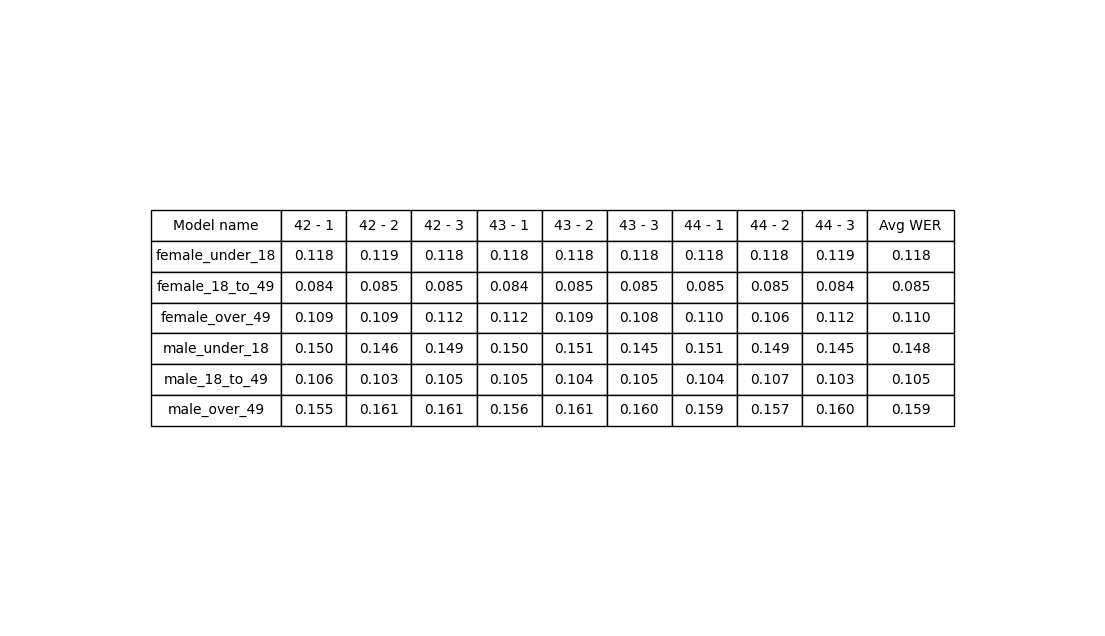

In [8]:
## Firstly, get the results to a table ##

import pandas as pd
import matplotlib.pyplot as plt

## Pivot the DataFrame to get the desired format for display ##
pivot_df = df.pivot_table(index='groups', columns=['seeds', 'rep'], values='scores')

## Rename the columns to "Seed X - Split Y" ##
pivot_df.columns = [f'{seed} - {rep}' for seed, rep in pivot_df.columns]

## Calculate the average for each row and add it as a new column ##
pivot_df['Avg WER'] = pivot_df.mean(axis=1)

## Reorder the rows to be female models first, then male models ##
pivot_df = pivot_df.reindex(['female_under_18', 'female_18_to_49', 'female_over_49', 'male_under_18', 'male_18_to_49', 'male_over_49'])

## Format all values to three decimal places ##
formatted_values = pivot_df.applymap(lambda x: f"{x:.3f}")

## Add "Model name" to the column names ##
formatted_values.reset_index(inplace=True)
formatted_values.columns = ['Model name'] + list(formatted_values.columns[1:])

## Plot the table ##
fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('tight')
ax.axis('off')

## Create the table with new column headers ##
the_table = ax.table(cellText=formatted_values.values, 
                     colLabels=formatted_values.columns,
                     cellLoc='center', 
                     loc='center')

## Adjust the font size and scale ##
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

## Adjust the width of the columns and the height of the cells ##
for (i, j), cell in the_table.get_celld().items():
    if j == 0:
        cell.set_width(0.12)  # Width of the first column
    elif j == len(formatted_values.columns) - 1:
        cell.set_width(0.08)  # Width of the Average column
    else:
        cell.set_width(0.06)  # Width of all other columns
    cell.set_height(0.05)  # The height of the cells

## Display the table ##
plt.show()


In [9]:
## Then test if the results are parametrical or not ##

import pandas as pd
from scipy.stats import shapiro, levene

## Perform Shapiro-Wilk Test for Normality ##
print("Shapiro-Wilk Test for Normality:")
for group_name, group_df in df.groupby('groups'):
    stat, p = shapiro(group_df['scores'])
    print(f"{group_name}: W-statistic={stat:.4f}, p-value={p:.4f}")

## Perform Levene's Test for Homogeneity of Variances ##
print("\nLevene’s Test for Homogeneity of Variances:")
grouped_scores = [group_df['scores'].values for _, group_df in df.groupby('groups')]
stat, p = levene(*grouped_scores)
print(f"Statistic={stat:.4f}, p-value={p:.4f}")

Shapiro-Wilk Test for Normality:
female_18_to_49: W-statistic=0.6173, p-value=0.0002
female_over_49: W-statistic=0.8958, p-value=0.2285
female_under_18: W-statistic=0.5358, p-value=0.0000
male_18_to_49: W-statistic=0.9364, p-value=0.5449
male_over_49: W-statistic=0.8509, p-value=0.0763
male_under_18: W-statistic=0.8403, p-value=0.0581

Levene’s Test for Homogeneity of Variances:
Statistic=3.2633, p-value=0.0129


In [10]:
## Then test if the results are due to seed randomness or not ##

from scipy.stats import kruskal

## Perform Kruskal-Wallis Test for each group separately ##
grouped = df.groupby('groups')
p_values = {}
for group_name, group in grouped:
    stat, p = kruskal(*[group[group['seeds'] == seed]['scores'] for seed in group['seeds'].unique()])
    p_values[group_name] = p
    print(f"The Kruskal-Wallis test for {group_name}: p-value={p:.4f}")

Kruskal-Wallis Test for female_18_to_49: p-value=1.0000
Kruskal-Wallis Test for female_over_49: p-value=0.9535
Kruskal-Wallis Test for female_under_18: p-value=0.5647
Kruskal-Wallis Test for male_18_to_49: p-value=0.9655
Kruskal-Wallis Test for male_over_49: p-value=0.7839
Kruskal-Wallis Test for male_under_18: p-value=0.9227


Kruskal-Wallis Test p-value: 6.290260524171122e-10


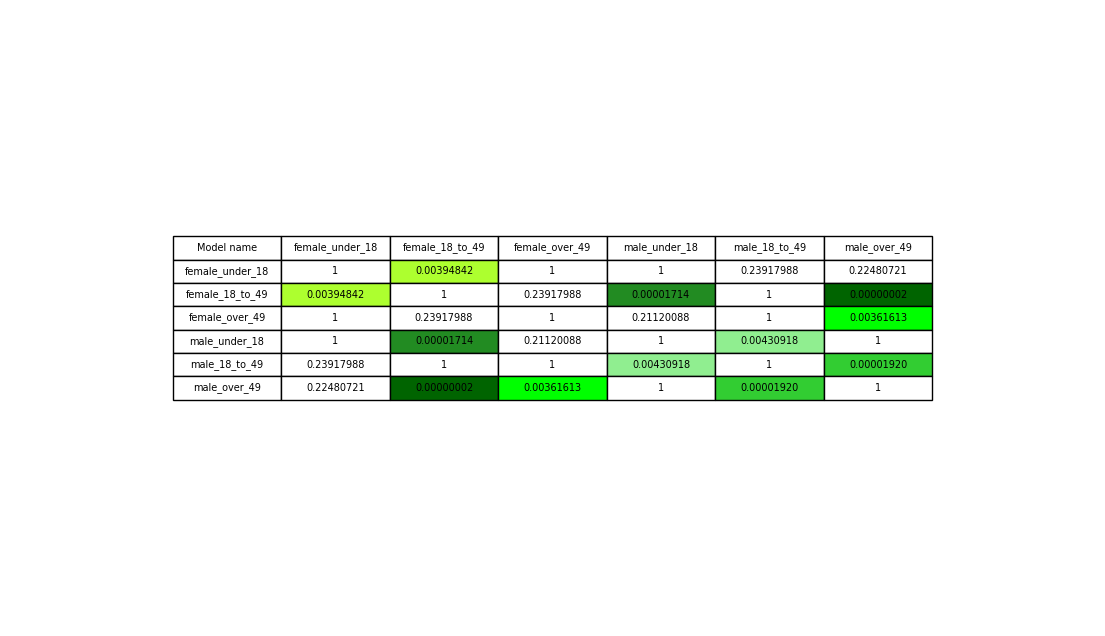

In [34]:
from scipy.stats import kruskal
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import pandas as pd

## Ensure the groups are sorted in the correct order, same as before ##
group_order = [
    'female_under_18', 'female_18_to_49', 'female_over_49',
    'male_under_18', 'male_18_to_49', 'male_over_49'
]
df['groups'] = pd.Categorical(df['groups'], categories=group_order, ordered=True)
df.sort_values('groups', inplace=True)

## Group the data by 'groups' for the Kruskal-Wallis test ##
grouped_data = [group['scores'].values for name, group in df.groupby('groups')]

## Perform the Kruskal-Wallis test ##
stat, p = kruskal(*grouped_data)
print('Kruskal-Wallis Test p-value:', p)

## Perform posthoc test if the Kruskal-Wallis test is statistically significant ##
if p < 0.05:
    p_values = sp.posthoc_dunn(df, val_col='scores', group_col='groups', p_adjust='bonferroni')
    
    ## Define a color map for statistical significance ##
    significance_level = 0.05
    color_map = {}
    
    unique_p_vals = pd.Series(p_values.where(p_values <= significance_level).stack().unique()).sort_values()
    colors = ['#006400', '#228B22', '#32CD32', '#00FF00', '#ADFF2F', '#90EE90']
    
    for i, p_val in enumerate(unique_p_vals):
        if i < len(colors):
            color_map[p_val] = colors[i]
        else:
            color_map[p_val] = colors[-1]
    
    ## Apply the color map to the p-values ##
    color_applied = p_values.applymap(lambda x: color_map.get(x, 'white'))
    
    ## Format all values to three decimal places ##
    formatted_values = p_values.applymap(lambda x: f"{x:.8f}" if x != 1 else "1")
    
    ## Add "Model name" to the column names ##
    formatted_values.reset_index(inplace=True)
    formatted_values.columns = ['Model name'] + list(formatted_values.columns[1:])
    color_applied.reset_index(inplace=True)
    color_applied.columns = ['Model name'] + list(color_applied.columns[1:])
    
    ## Set the color of the 'Model name' column to white ##
    color_applied['Model name'] = 'white'
    
    ## Create a figure to display the table ##
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('tight')
    ax.axis('off')
    
    ## Display the table ##
    the_table = ax.table(cellText=formatted_values.values,
                         colLabels=formatted_values.columns,
                         cellLoc='center', 
                         loc='center',
                         cellColours=color_applied.values)
    
    ## Adjust table scale ##
    the_table.scale(0.7, 1.4)
    
    
    plt.show()
else:
    print("The Kruskal-Wallis test is not statistically significant, no posthoc test performed.")


Kruskal-Wallis Test p-value: 6.290260524171122e-10


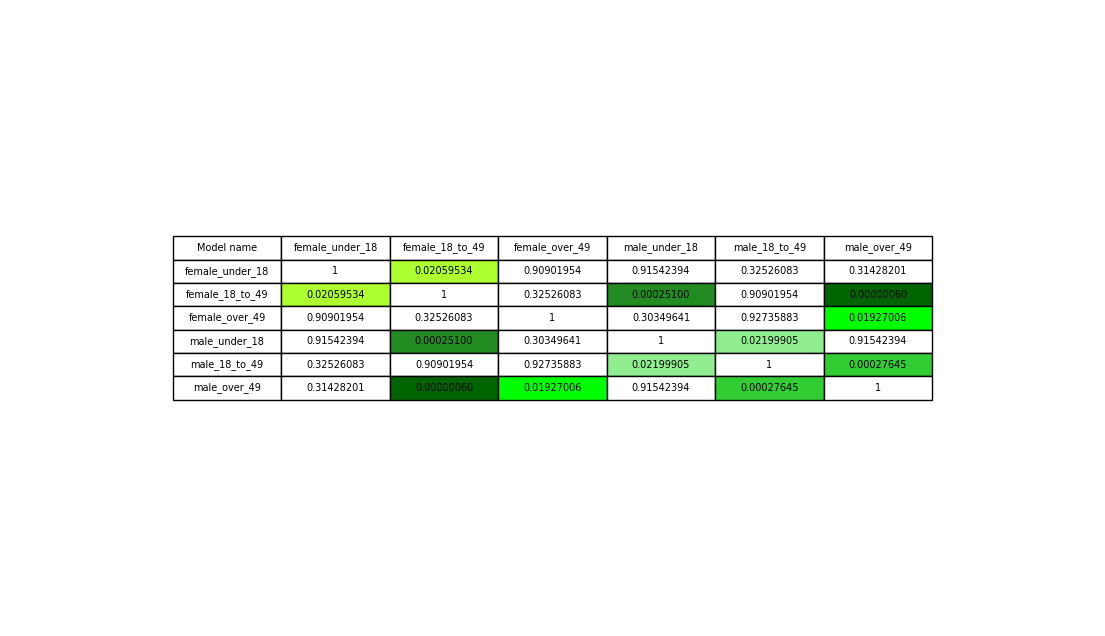

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import scikit_posthocs as sp

## Ensure the groups are sorted in the correct order, same as before ##
group_order = [
    'female_under_18', 'female_18_to_49', 'female_over_49',
    'male_under_18', 'male_18_to_49', 'male_over_49'
]
df['groups'] = pd.Categorical(df['groups'], categories=group_order, ordered=True)
df.sort_values('groups', inplace=True)

## Group the data by 'groups' for the Kruskal-Wallis test ##
grouped_data = [group['scores'].values for name, group in df.groupby('groups')]

## Perform the Kruskal-Wallis test ##
stat, p = kruskal(*grouped_data)
print('Kruskal-Wallis Test p-value:', p)

## Perform posthoc test if the Kruskal-Wallis test is statistically significant ##
if p < 0.05:
    p_values = sp.posthoc_nemenyi(df, val_col='scores', group_col='groups')
    
    ## Define a color map for statistical significance ##
    significance_level = 0.05
    color_map = {}
    
    unique_p_vals = pd.Series(p_values.where(p_values <= significance_level).stack().unique()).sort_values()
    colors = ['#006400', '#228B22', '#32CD32', '#00FF00', '#ADFF2F', '#90EE90']
    
    for i, p_val in enumerate(unique_p_vals):
        if i < len(colors):
            color_map[p_val] = colors[i]
        else:
            color_map[p_val] = colors[-1]
    
    ## Apply the color map to the p-values ##
    color_applied = p_values.applymap(lambda x: color_map.get(x, 'white'))
    
    ## Format all values to three decimal places, including trailing zeros ##
    formatted_values = p_values.applymap(lambda x: f"{x:.8f}" if x != 1 else "1")
    
    ## Add "Model name" to the column names ##
    formatted_values.reset_index(inplace=True)
    formatted_values.columns = ['Model name'] + list(formatted_values.columns[1:])
    color_applied.reset_index(inplace=True)
    color_applied.columns = ['Model name'] + list(color_applied.columns[1:])
    
    ## Set the color of the 'Model name' column to white ##
    color_applied['Model name'] = 'white'
    
    ## Create a figure to display the table ##
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('tight')
    ax.axis('off')
    
    ## Display the table ##
    the_table = ax.table(cellText=formatted_values.values,
                         colLabels=formatted_values.columns,
                         cellLoc='center', 
                         loc='center',
                         cellColours=color_applied.values)
    
    ## Adjust table scale ##
    the_table.scale(0.7, 1.4)
    
    plt.show()
else:
    print("The Kruskal-Wallis test is not statistically significant, no posthoc test performed.")


In [ ]:
## Key findings:
## female_18_to_49 vs female_under_18 is statistically significant
## female_18_to_49 vs male_under_18 is statistically significant
## male_18_to_49 vs male_under_18 is statistically significant